This function is written to plot the scaling law of the PDE and compare it with the scaling the we get from the ML model. This function can also we used to plot the other long term behaviour of the ML model.

To do list for today:


1- Plotting the scaling for earthquakes first. Instead of plotting it for earthqukes in the long simulation plot it for earthquakes with different intial conditions.

In [1]:
# loading the data 
from Forward2d import forwardmodel
import cte_eq
import pickle
import numpy as np
import sys
sys.path.append('./..')
from ProcessFunctions import find_Aisv2,Find_a_i,find_Aisv2_onlyv

import ProcessFunctions
import matplotlib.pyplot as plt
import cte
from scipy import integrate
import torch
import torch.nn as nn
import seaborn as sns 


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# T_final=10500
# mu=3e10
# drs=0.012
# N_m_v=20        # number of modes that they have considered
# N_m_theta=20    # number of modes that they have considered
# N_m_load=30

list_Nv=[20]
list_Ntheta=[20]
# Nxout=cte_eq.Nxout
# Ntout=cte_eq.Ntout



In [4]:
T_final=10500
Ntout=cte_eq.Ntout
Nxout=cte_eq.Nxout
drs=0.012
mu=3e10

data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
# VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']

In [5]:
# Loading POD modes


data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyontheta'+'drs'+str(drs)+".npz"

PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
# VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']

In [6]:
def findscalingquantities(pdot,t,v,delta_x,V_event=1e-2): 
    flag_event=False
    T1s=[] # this is the time of the start of events
    T2s=[] # this is the time of the end of events
    length_ruptures=[] # this is the length of the rupture
    pots=[] # integral of pdot over the event duration
    for i in range(v.shape[0]): # first dimension is time
        if np.max(v[i,:])>V_event and flag_event==False:
            start=i
            T1s.append(t[i,0])
            flag_event=True
            print(i)
        if np.max(v[i,:])<V_event and flag_event==True:
            end=i
            flag_event=False
            T2s.append(t[i,0])
            print(i)
            # check from start to end for all elements of v[start,:] to v[end,:] which elements had v >v_event in one line, from this you can find the event extent
            ruptured=np.where(v[start:end,:]>V_event,1,0)
            # find the locations at which at least there is one element that is ruptured
            ruptured=np.sum(ruptured,axis=0)
            ruptured=(ruptured>0)
            # summing number of ruptured elements
            num_ruptured_elements=np.sum(ruptured)
            # then the rupture length of this event is given by 
            length_rupture=num_ruptured_elements*delta_x
            length_ruptures.append(length_rupture)
            potency_of_event=integrate.cumtrapz(pdot[start:end+1],t[start:end+1,0])    
            pots.append(potency_of_event[-1])
    return  T1s,T2s,length_ruptures,pots

In [7]:
def Gut(Mw,NpointsM=30):
    CumNumber=np.array([])
    c1=np.min(Mw)
    c2=np.max(Mw)-.0001 # To remove log10(0) error
    print(c1)
    print(c2)
    c=np.linspace(c1,c2,NpointsM)
    print(c)
    for i in range(c.size):
        CumNumber=np.append(CumNumber,(sum(j > c[i] for j in Mw)))
    return c,CumNumber  

In [8]:
# Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/transfer/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m)+"coeff"+str(coeff)+"number"+str(index)"
T_final_run = 350 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_v=20 # number of modes that they have considered
N_m_theta=20 # number of modes that they have considered
coeff=1 # How the inital conditions are from the chaotic attractor
number=10 # Which one do you want to load
N_cut=2000
# loading time series:
N_m_load=30
find_scaling=True
X_full=np.empty((1,N_m_load*2))
Y_full=np.empty((1,N_m_load*2))
L=240e3
N_remove=0
T1s_all=[]
T2s_all=[]
length_ruptures_all=[]
pots_all=[]
number_to_load=5
for number in range(number_to_load):
    data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
    data_smaple=np.load(data_dir)

    V_ox=data_smaple['array1']
    theta_ox=data_smaple['array2']
    t_ox=data_smaple['array3']
    if find_scaling:
        Nx=(V_ox.shape[1])
        delta_x=L/Nx
        # pdot is the the integral of v over space
        pdot=np.sum(V_ox,axis=1)*delta_x
        T1s,T2s,length_ruptures,pots=findscalingquantities(pdot,t_ox,V_ox,delta_x,V_event=1e-2)
        if len(T2s) == len(T1s) - 1:
            T1s = T1s[:-1]
        # removing the first two elements of the array to get rid of th transients
        T1s=T1s[N_remove:]
        T2s=T2s[N_remove:]
        length_ruptures=length_ruptures[N_remove:]
        pots=pots[N_remove:]

        T1s_all+=T1s
        T2s_all+=T2s
        length_ruptures_all+=length_ruptures
        pots_all+=pots
        


    # removing data with probability p
    xi=0
    p_remove=np.tanh(xi*np.max(V_ox,axis=1))
    Nt_sample=p_remove.shape[0]
    print( "number of points in this member is:", Nt_sample)
    keep_mask_sample=np.random.rand(Nt_sample) > p_remove
    # We work with log10 of V_ox and theta_ox:
    V_ox=np.log10(V_ox)
    theta_ox=np.log10(theta_ox)
    A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
    A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
    # concatenating the two arrays
    A=np.concatenate((A_v,A_theta),axis=1)
    X_onesimulation=A[:-1,:]         # current step
    Y_onesimulation=A[1:,:]-A[:-1,:] # next step minus the current step
    print("shape of X_onesimulation before is",X_onesimulation.shape)
    X_onesimulation=X_onesimulation[keep_mask_sample[:-1]]
    Y_onesimulation=Y_onesimulation[keep_mask_sample[:-1]]
    print("shape of X_onesimulation after is",X_onesimulation.shape)

    X_full=np.append(X_full,X_onesimulation,axis=0)
    Y_full=np.append(Y_full,Y_onesimulation,axis=0)
    print("number is " +str(number)+ " size of data in this simulation is " +str(X_onesimulation.shape[0])+" total size is " + str(X_full.shape[0]))

# removing the first row which is empty
X_full=X_full[1:,:]
Y_full=Y_full[1:,:]

# print(np.max(X_full))
print(np.max(Y_full))
# Loading the the numpy arrays Input and Output which are generated for imposing dissipiation far away from the attractor
# # commenting here:
# data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/EarthquakeEllipticShell_radi_outer"+str(radi_outer)+"radi_inner"+str(radi_inner)+"PODappliedseperately.npz"

# data_smaple=np.load(data_dir)
# Input_X=data_smaple['Input']
# Output_Y=data_smaple['Output']
# # appending the Input_X to the X_full and Output_Y to the Y_full
# # appending the Input_X to the X_full and Output_Y to the Y_full, but append from the begining of the array
# print(np.max(Output_Y))
# X_full=np.append(Input_X,X_full,axis=0)
# Y_full=np.append(Output_Y,Y_full,axis=0)
# # untill here

# deleting some colomns from X_full and Y_full that are should not be included based on N_m_v and N_m_theta
# index of the columns that should be deleted
index_delete=np.array([])
if N_m_v<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_v,N_m_load))
if N_m_theta<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_load+N_m_theta,2*N_m_load))


# Convert the array elements to integers
index_delete = index_delete.astype(int)

X_full=np.delete(X_full,index_delete,axis=1)
Y_full=np.delete(Y_full,index_delete,axis=1)
print("index of the columns that are deleted are:")
print(index_delete)

print(X_full.shape)
print("size of the data is " +str(X_full.shape[0]))
# 50, 55, 59, 63, 72, 73,79,81

0
1
52
142
212
292
347
3044
3113
3328
3369
3633
3690
3794
3842
4044
4104
5282
5313
6666
number of points in this member is: 6727
shape of X_onesimulation before is (6726, 60)
shape of X_onesimulation after is (6726, 60)
number is 0 size of data in this simulation is 6726 total size is 6727
0
2
13
1366
1442
1739
1838
1999
2056
2206
2261
3629
3671
5096
5161
5353
5382
5544
5610
5787
5836
6901
6952
8542
number of points in this member is: 8607
shape of X_onesimulation before is (8606, 60)
shape of X_onesimulation after is (8606, 60)
number is 1 size of data in this simulation is 8606 total size is 15333
0
1041
1109
1278
1327
1557
1613
1729
1779
2007
2053
3116
3168
4890
4963
5160
5181
5431
5520
6717
6750
8100
number of points in this member is: 8138
shape of X_onesimulation before is (8137, 60)
shape of X_onesimulation after is (8137, 60)
number is 2 size of data in this simulation is 8137 total size is 23470
40
1403
1497
1975
2077
2272
2316
2516
2597
5026
5095
5288
5330
5530
5584
5697
5744

In [9]:
print(len(T1s_all),len(T2s_all),len(length_ruptures_all),len(pots_all))

56 56 56 56


In [10]:
T1s_all=np.array(T1s_all)
T2s_all=np.array(T2s_all)
length_ruptures_all=np.array(length_ruptures_all)
pots_all=np.array(pots_all)
moment_events=mu*pots_all
log_10_moment_events=np.log10(moment_events)
mags,cumN=Gut(log_10_moment_events)


12.947242385011354
16.758041766287153
[12.94724239 13.07864926 13.21005614 13.34146301 13.47286989 13.60427676
 13.73568364 13.86709051 13.99849739 14.12990426 14.26131114 14.39271801
 14.52412489 14.65553176 14.78693864 14.91834551 15.04975239 15.18115926
 15.31256614 15.44397301 15.57537989 15.70678676 15.83819364 15.96960051
 16.10100739 16.23241427 16.36382114 16.49522802 16.62663489 16.75804177]


In [11]:
print("T1s",np.array(T1s)/cte.t_yr)
print("T2s",np.array(T2s)/cte.t_yr)
print("length_rupture",length_ruptures)

T1s [ 22.58352132  46.48434498 127.1170595  127.11706687 154.88794344
 160.96426195 233.63792872 262.04347074 322.52222708 325.10170984
 333.38379949 333.38380605]
T2s [ 22.58352254  46.48434607 127.11706369 127.11707015 154.88794497
 160.96426331 233.63793019 262.04347625 322.52222844 325.1017115
 333.38380333 333.38380942]
length_rupture [11718.75, 10312.5, 86953.125, 163593.75, 18046.875, 15000.0, 11953.125, 62812.5, 7968.75, 14062.5, 87187.5, 162890.625]


In [12]:
# # finding the mements, durations, and are for each event
# flag_event=False
# V_event=1e-2
# T1s=[] # this is the time of the start of events
# T2s=[] # this is the time of the end of events
# length_ruptures=[] # this is the length of the rupture
# pots=[] # integral of pdot over the event duration
# for i in range(1,20000):
#     if np.max(v[i,:])>V_event and flag_event==False:
#         start=i
#         T1s.append(t[i,0])
#         flag_event=True
#     if np.max(v[i,:])<V_event and flag_event==True:
#         end=i
#         flag_event=False
#         T2s.append(t[i,0])
#         # check from start to end for all elements of v[start,:] to v[end,:] which elements had v >v_event in one line, from this you can find the event extent
#         ruptured=np.where(v[start:end,:]>V_event,1,0)
#         # find the locations at which at least there is one element that is ruptured
#         ruptured=np.sum(ruptured,axis=0)
#         ruptured=(ruptured>0)
#         # summing number of ruptured elements
#         num_ruptured_elements=np.sum(ruptured)
#         # then the rupture length of this event is given by 
#         length_rupture=num_ruptured_elements*delta_x
#         length_ruptures.append(length_rupture)
#         potency_of_event=integrate.cumtrapz(pdot[start-1:end],t[start-1:end,0])    
#         pots.append(potency_of_event[-1])
# # now I have everything to plot the scaling law for the earthquake problem

In [13]:
# T1s=np.array(T1s)
# T2s=np.array(T2s)
# length_ruptures=np.array(length_ruptures)
# pots=np.array(pots)
# if np.size(T2s)==np.size(T1s)-1:
#     T1s=T1s[:-1]

In [14]:
# print(T1s.shape)

In [15]:
cumN

array([55., 54., 54., 54., 54., 54., 54., 54., 54., 54., 52., 51., 47.,
       42., 33., 26., 22., 22., 22., 22., 22., 22., 21., 21., 15., 11.,
        9.,  3.,  2.,  1.])

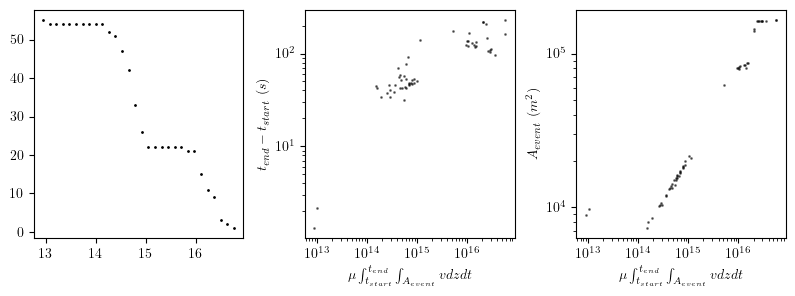

In [16]:
# make a figure with
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

axs[0].scatter(mags, cumN, s=1, color='black')
# plotting in loglog scale the length of events in y axis and moment in x axis

axs[1].scatter(moment_events, T2s_all-T1s_all , s=1, color='black',alpha=0.5)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[1].set_ylabel(r"$t_{end}-t_{start}$ $(s)$")


axs[2].scatter(moment_events, length_ruptures_all , s=1, color='black',alpha=0.5)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[2].set_ylabel(r"$A_{event}$ ($m^2$)")
plt.tight_layout()

In [17]:
# loading the ML model g1 and g2
# the model g1 is saved using:
class Forwardmap(nn.Module):
    def __init__(self, N_m, dropout_rate=0.2, negative_slope=0.01):
        super().__init__()
        self.hidden1 = nn.Linear(N_m, 2 * N_m)
        self.act1 = nn.LeakyReLU(negative_slope)
        self.hidden2 = nn.Linear(2 * N_m, 4 * N_m)
        self.act2 = nn.LeakyReLU(negative_slope)
        self.hidden3 = nn.Linear(4 * N_m, 4 * N_m)
        self.act3 = nn.LeakyReLU(negative_slope)
        self.hidden4 = nn.Linear(4 * N_m, 2 * N_m)
        self.act4 = nn.LeakyReLU(negative_slope)
        self.output = nn.Linear(2 * N_m, N_m)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.dropout(x)
        x = self.act2(self.hidden2(x))
        x = self.dropout(x)
        x = self.act3(self.hidden3(x))
        x = self.dropout(x)
        x = self.act4(self.hidden4(x))
        x = self.dropout(x)
        x = self.output(x)
        return x
version=0



In [18]:
i=0
model=Forwardmap(list_Nv[i]+list_Ntheta[i])
model.load_state_dict(torch.load(
    "/central/groups/astuart/hkaveh/Data/LearnROM/Earthquake2D_ROM_POD_separate_onV_theta"
    + str(version)
    + "N_m_v"
    + str(N_m_v)
    + "N_m_theta"
    + str(N_m_theta)
    + ".pt",
    map_location=torch.device('cpu')
))
model.eval()
index_delete=np.array([])
if list_Nv[i]<N_m_load:
    index_delete=np.append(index_delete,np.arange(list_Nv[i],N_m_load))
if list_Ntheta[i]<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_load+list_Ntheta[i],2*N_m_load))

In [19]:
X_full.shape

(39415, 40)

In [20]:
directory='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/sigma'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
Sigma_v=np.load(directory)['Sigma_v']
Sigma_theta=np.load(directory)['Sigma_theta']

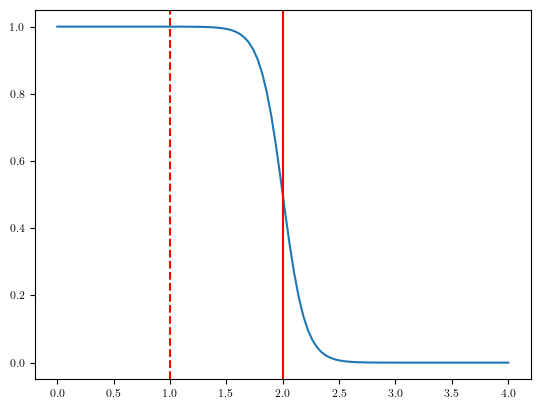

In [71]:
Beta=10
lambda_dissipation=0.4
rho=2
x_plot_test=np.linspace(0,2*rho,100)
plt.plot(x_plot_test,1/(1+np.exp(Beta*(x_plot_test-rho))))
plt.axvline(x=rho, color='r')
plt.axvline(x=rho-1, color='r', linestyle='--')

In [72]:
def find_logvmax(alpha):
    if not isinstance(alpha, torch.Tensor):
        alpha = torch.tensor(alpha, dtype=phi_torch.dtype, device=phi_torch.device)
    v = torch.matmul(phi_torch, alpha).unsqueeze(1) + q_bar_v_torch
    logvmax = torch.max(v).detach()  # Get the maximum value in v
    return logvmax

In [73]:
def dissipation_factor(xk,rho,Sigma,Beta=10):
    # u=xk/Sigma # normalize by the std
    alpha=xk[:,:N_m_v]
    logvmax=find_logvmax(alpha.T)
    # norm_u=torch.norm(u)
    output=1/(1+torch.exp(Beta*(logvmax-rho)))
    return output

Sigma=np.concatenate((Sigma_v,Sigma_theta))
Sigma = torch.tensor(Sigma, dtype=torch.float32, device=device)

In [74]:
phi=U_v[:,:N_m_load]    # This contains the eigen mode for velocity
phi[:,:20].shape
phi_torch =     torch.tensor(phi[:,:20], dtype=torch.float32, device=device)
q_bar_v_torch = torch.tensor(q_bar_v, dtype=torch.float32, device=device)

In [75]:
N_it=int(100000)
xk=X_full[-1,:].reshape(1,N_m_v+N_m_theta)
xk=torch.tensor(xk, dtype=torch.float32)
xk.to(device)
forecast=xk.detach().numpy().reshape(N_m_v+N_m_theta,1)
for i in range(N_it):
    dissipate=dissipation_factor(xk,rho,Sigma)
    ykp1=(model(xk))
    # print(dissipate)
    xkp1=(ykp1+xk)* dissipate + (1-dissipate)*(lambda_dissipation*xk) # equation 8 and 9 of the Learning Dissipative Dynamics in Chaotic Systems
    numpy_vector = xkp1.detach().numpy().reshape(N_m_v+N_m_theta,1)
    forecast = np.hstack([forecast, numpy_vector])
    xk=xkp1 
plt.plot(forecast[0,:])

In [ ]:
dissipate

tensor(1.)

(0.0, 80000.0)

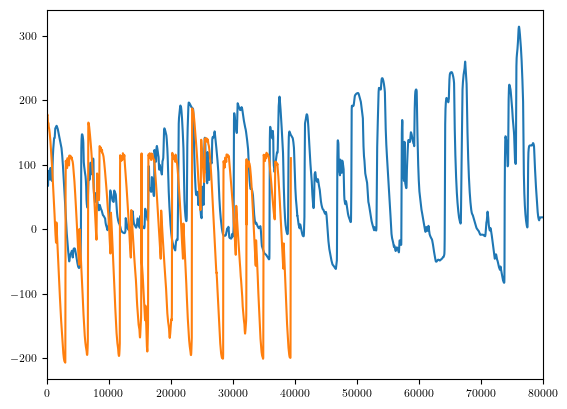

In [ ]:
plt.plot(forecast[0,:])
plt.plot(X_full[:,0])
plt.xlim(left=0,right=80000)
# plt.ylim(bottom=-5000,top=5000)

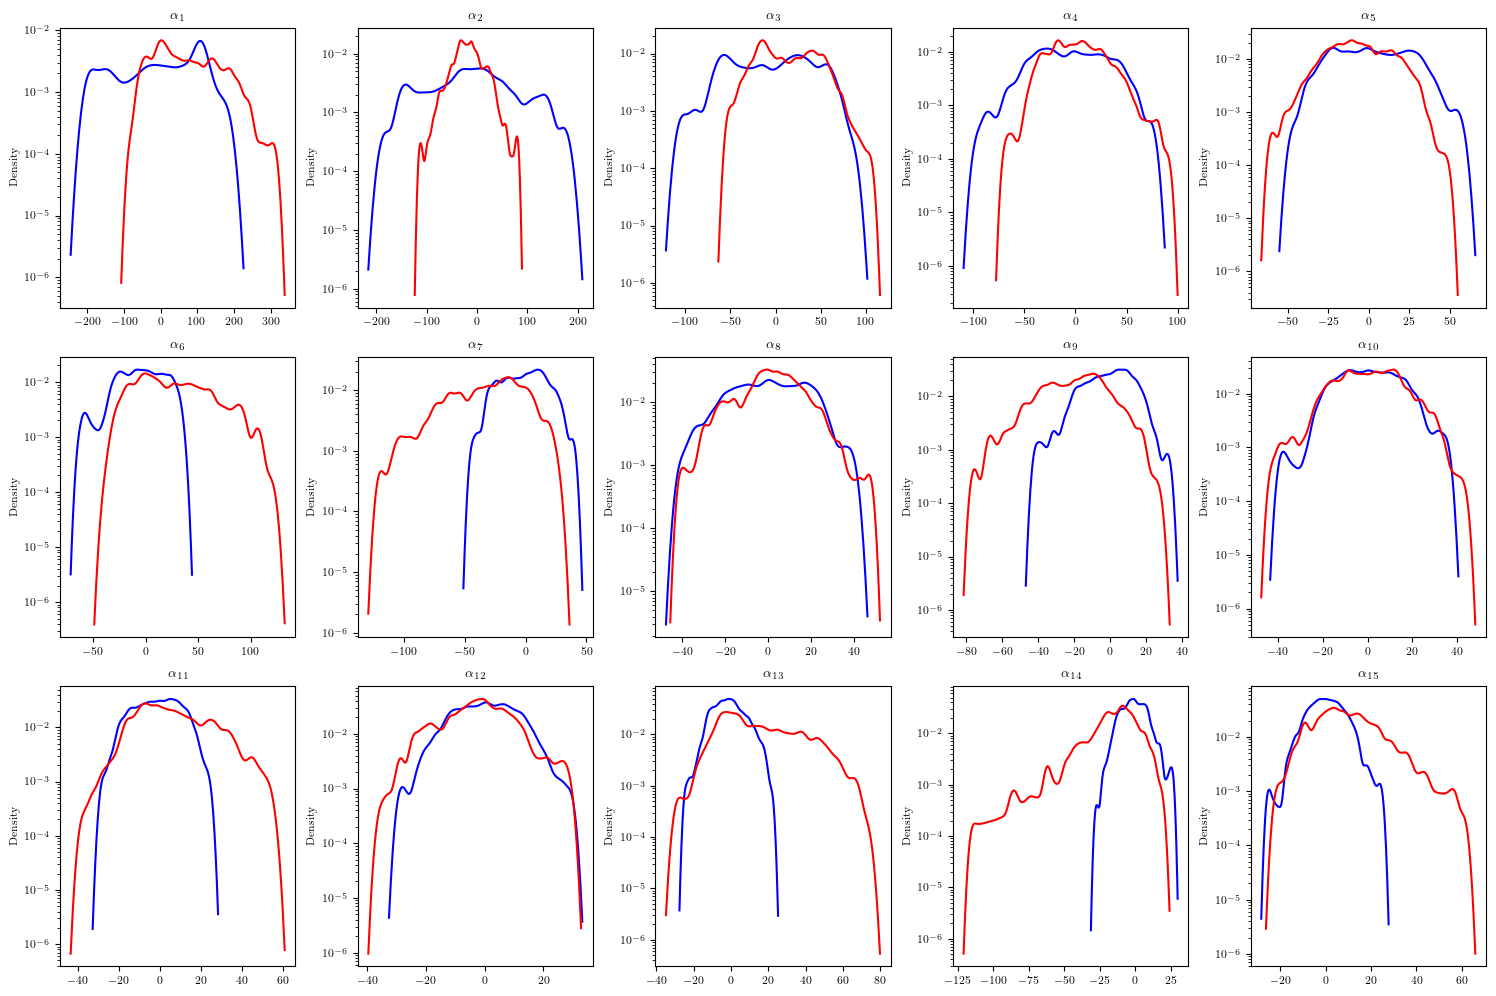

In [ ]:
# Create a figure and axis objects
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(15):
    sns.kdeplot(X_full[:, i], ax=axs[i],color='blue')
    sns.kdeplot(forecast[i,:],ax=axs[i],color='red')
    axs[i].set_title(r'$\alpha_{{{}}}$'.format(i+1))
    axs[i].set_yscale("log")
# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
phi=U_v[:,:N_m_load]    # This contains the eigen mode for velocity

In [ ]:
forecast.shape

(40, 100001)

In [ ]:


# %% Defining model
class Forwardmapdt(nn.Module):
    def __init__(self,N_m_v, dropout_rate=0.2, negative_slope=0.01):
        super().__init__()
        self.hidden1=nn.Linear(N_m_v+1,2*N_m_v)
        self.act1=nn.LeakyReLU(negative_slope)
        self.hidden2=nn.Linear(2*N_m_v,4*N_m_v)
        self.act2=nn.LeakyReLU(negative_slope)
        self.hidden3=nn.Linear(4*N_m_v,4*N_m_v)
        self.act3=nn.LeakyReLU(negative_slope)
        self.hidden4=nn.Linear(4*N_m_v,2*N_m_v)
        self.act4=nn.LeakyReLU(negative_slope)
        self.output=nn.Linear(2*N_m_v,1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x = self.dropout(x)
        x=self.act2(self.hidden2(x))
        x = self.dropout(x)
        x=self.act3(self.hidden3(x))
        x = self.dropout(x)
        x=self.act4(self.hidden4(x))
        x = self.dropout(x)
        x=(self.output(x))
        return x

In [ ]:
logvmax_reducedmodels=np.zeros((N_it+1,3))
times=np.zeros((N_it+1,3))
# Finding the three dimensional velocities matrix from the ROM
# make a figure with two subplots:
size_x=U_v.shape[0]
V_ox_ROMs=[]
t_ox_ROMs=[]
for i in range(1):
    # organize the input
    X_input_partial=forecast.T # xinput without the vmax
    # finding vmax
    for j in range(N_it+1):
        logvmax_reducedmodels[j,i]=find_logvmax(X_input_partial[j,:list_Nv[i]].T)  


    X_ML_scaled=X_input_partial[:,:list_Nv[i]]
    X_ML_scaled = np.concatenate((X_ML_scaled, logvmax_reducedmodels[:,i].reshape(N_it+1,1)), axis=1)
    # load model:
    modeldt=Forwardmapdt(list_Nv[i])
    modeldt.load_state_dict( torch.load("/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/EQ_ROM_g2"+str(version)+"N_m_v"+str(N_m_v)+".pt"))
    modeldt.eval()
    X_ML_scaled_tensor = torch.tensor(X_ML_scaled, dtype=torch.float32)
    X_ML_scaled_tensor.to(device)
    dt_ML=modeldt(X_ML_scaled_tensor)
    dt_ML_detach=dt_ML.detach().numpy()
    dt_ML_detach_scaled=dt_ML_detach
    dt_ML_realtime=10**dt_ML_detach_scaled
    time_ML=np.cumsum(dt_ML_realtime,dtype=np.float64)
    # # plt.plot(dt_ML.detach().numpy(),label='Predicted')  
    # time_ML=time_ML.reshape(-1,1,1) # adding three dimension to time_ML
    # # 
    U_ROM=U_v[:,0:list_Nv[i]]
    
    V_ox_ROM=np.empty((N_it+1,size_x))
    t_ox_ROM=np.ones((N_it+1,size_x))
    # #appending vmax
    vmax=[]
    for j in range(N_it+1):
        V_snapshot = U_ROM @ (forecast[:list_Nv[i], j]) + q_bar_v.reshape(size_x,)
        # V_snapshot = V_snapshot[:size_x ].reshape(1, size_x)
        vmax.append(np.max(V_snapshot))
        V_ox_ROM[j,:]=10**(V_snapshot)
        t_ox_ROM[j,:]=time_ML[j]*np.ones((1,size_x))
        print()
        
    pdot=np.sum(V_ox_ROM,axis=1)*delta_x
    T1s_ROM,T2s_ROM,length_ruptures_ROM,pots_ROM=findscalingquantities(pdot,t_ox_ROM,V_ox_ROM,delta_x,V_event=1e-2)
    T1s_ROM=np.array(T1s_ROM)
    T2s_ROM=np.array(T2s_ROM)
    length_ruptures_ROM=np.array(length_ruptures_ROM)
    pots_ROM=np.array(pots_ROM)
    moment_ROM=mu*pots_ROM
    log_10_moment_events_ROM=np.log10(moment_ROM)
    mags_ROM,cumN_ROM=Gut(log_10_moment_events_ROM)
    if len(T2s_ROM) == len(T1s_ROM) - 1:
        T1s_ROM = T1s_ROM[:-1]

In [ ]:
T_final_ROM=time_ML[-1]/cte.t_yr

/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  
/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.


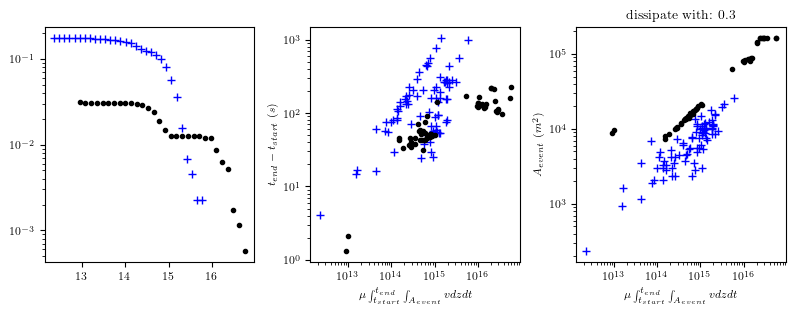

In [ ]:
# make a figure with
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

axs[0].plot(mags_ROM, cumN_ROM/T_final_ROM, '.',color='blue',label='ROM',marker='+')
axs[0].plot(mags, cumN/(number_to_load*T_final_run), '.', color='black',label="ROM")
axs[0].set_yscale("log")
# plotting in loglog scale the length of events in y axis and moment in x axis

axs[1].plot(moment_ROM, T2s_ROM-T1s_ROM ,  '.', color='blue',label="ROM",marker="+")
axs[1].plot(moment_events, T2s_all-T1s_all ,  '.', color='black',label='PDE')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[1].set_ylabel(r"$t_{end}-t_{start}$ $(s)$")

axs[2].plot(moment_ROM, length_ruptures_ROM ,  '.', color='blue',label="ROM",marker="+")
axs[2].plot(moment_events, length_ruptures_all , '.', color='black',label="PDE")

axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[2].set_ylabel(r"$A_{event}$ ($m^2$)")
plt.tight_layout()
plt.title("dissipate with: "+
str(lambda_dissipation))
#
plt.savefig("dissipate with: "+str(lambda_dissipation)+".png")

I think it makes sense the MFD is more a long term simulation whereas the other two are transient behaviours, we tried to fit the transient behaviour and not the long term behaviour.

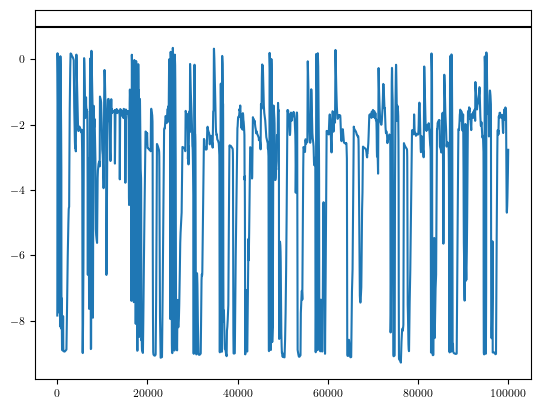

In [70]:
plt.plot(logvmax_reducedmodels[:,0])
plt.axhline(rho-1,color="black")